# Multi-period OPF example

In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from nygrid.run_nygrid import NYGrid

In [46]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Grid data directory: D:\EERL\OneMet\NYgrid-python\data\grid
Figure directory: D:\EERL\OneMet\NYgrid-python\figures
Results directory: D:\EERL\OneMet\NYgrid-python\results


## Read grid data

In [47]:
# Area names outside NYISO
bus_area_name = {
    1: 'NE',
    2: 'UPNY',
    3: 'DNNY',
    4: 'IESO',
    6: 'PJM',
}

# Read bus properties
filename = os.path.join(grid_data_dir, 'bus_prop.csv')
bus_prop = pd.read_csv(filename, index_col=0)
bus_prop = bus_prop[['BUS_I', 'BUS_AREA']]
bus_prop['BUS_AREA_NAME'] = bus_prop['BUS_AREA'].map(bus_area_name)

# Read NY bus-zone allocation
filename = os.path.join(grid_data_dir, 'bus_ny_type_zone_population.csv')
ny_bus_zone = pd.read_csv(filename)

ny_bus_zone = ny_bus_zone[['busIdx', 'zoneID']]
ny_bus_zone = ny_bus_zone.sort_values(by=['busIdx']).reset_index(drop=True).set_index('busIdx')

# Combine data for NY and outside NY
bus_zone_alloc = pd.merge(bus_prop, ny_bus_zone, left_on='BUS_I', right_index=True, how='left')
bus_zone_alloc.loc[bus_zone_alloc['zoneID'].isna(), 'zoneID'] = bus_zone_alloc.loc[bus_zone_alloc['zoneID'].isna(), 'BUS_AREA_NAME']
bus_zone_alloc = bus_zone_alloc[['BUS_I', 'zoneID']]
# bus_zone_alloc['BUS_I'] = 'Bus'+bus_zone_alloc['BUS_I'].astype(str)

# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = bus_zone_alloc.set_index('BUS_I').to_dict()['zoneID']
bus_names = list(bus_zone_alloc.keys())
bus_names_str = [f'Bus{i}' for i in bus_names]

In [48]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
load_profile.index.freq = 'H'


# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gen_profile.index.freq = 'H'

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmax_profile.index.freq = 'H'

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmin_profile.index.freq = 'H'

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genramp30_profile.index.freq = 'H'

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost0_profile.index.freq = 'H'

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost1_profile.index.freq = 'H'


In [49]:
load_profile.sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-29 16:00:00    93203.379573
2018-08-29 15:00:00    93195.481205
2018-08-28 16:00:00    93096.897866
2018-08-28 17:00:00    92926.644148
2018-08-29 14:00:00    92834.789049
                           ...     
2018-05-13 05:00:00    35697.114653
2018-10-14 04:00:00    35637.438092
2018-05-14 03:00:00    35606.429683
2018-05-13 03:00:00    35419.794164
2018-05-13 04:00:00    35330.279322
Length: 8760, dtype: float64

## Multi-period OPF

### Without initial conditions

In [50]:
# Only run for one day
d = 240
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-08-29 00:00:00
End time: 2018-08-30 23:00:00


In [51]:
# Read DC line property file
filename = os.path.join(grid_data_dir, 'dcline_prop.csv')
dcline_prop = pd.read_csv(filename, index_col=0).to_numpy()
dcline_prop


array([[  21.      ,   80.      ,    1.      ,   12.666667,    0.      ,
           0.      ,    0.      ,    1.01    ,    1.      , -530.      ,
         530.      , -100.      ,  100.      , -100.      ,  100.      ,
           0.      ,    0.      ],
       [ 124.      ,   79.      ,    1.      ,  660.      ,    0.      ,
           0.      ,    0.      ,    1.01    ,    1.      , -660.      ,
         660.      , -100.      ,  100.      , -100.      ,  100.      ,
           0.      ,    0.      ],
       [ 125.      ,   81.      ,    1.      ,  599.166667,    0.      ,
           0.      ,    0.      ,    1.01    ,    1.      , -660.      ,
         660.      , -100.      ,  100.      , -100.      ,  100.      ,
           0.      ,    0.      ],
       [ 125.      ,   81.      ,    1.      ,  223.166667,    0.      ,
           0.      ,    0.      ,    1.01    ,    1.      , -660.      ,
         660.      , -100.      ,  100.      , -100.      ,  100.      ,
           0.      

In [52]:
filename = os.path.join(grid_data_dir, 'esr_prop.csv')
esr_prop = pd.read_csv(filename, index_col=0).to_numpy()
# esr_prop = esr_prop[8:10, :]
esr_prop

array([['Gilboa 1 (IIFO - 1/1/2019)', 42, 1, 280.0, 291.8, 0.67, 0.67, 0,
        3000, 1500, 1500, 0.005, 0.005],
       ['Gilboa 2', 42, 1, 280.0, 292.7, 0.67, 0.67, 0, 3000, 1500, 1500,
        0.005, 0.005],
       ['Gilboa 3', 42, 1, 280.0, 291.9, 0.67, 0.67, 0, 3000, 1500, 1500,
        0.005, 0.005],
       ['Gilboa 4', 42, 1, 280.0, 292.5, 0.67, 0.67, 0, 3000, 1500, 1500,
        0.005, 0.005],
       ['Lewiston PS', 56, 1, 230.0, 240.0, 0.59, 0.59, 0, 2880, 1440,
        1440, 0.005, 0.005],
       ['North County Energy Storage', 47, 1, 20.0, 20.0, 0.85, 0.85, 0,
        200, 100, 100, 0.005, 0.005],
       ['zzAgg_J_ES__1', 82, 1, 2.0, 2.0, 0.85, 0.85, 0, 8, 4, 4, 0.005,
        0.005],
       ['zzAgg_K_FC__1', 80, 1, 18.5, 18.5, 0.85, 0.85, 0, 74, 37, 37,
        0.005, 0.005],
       ['A_ESR_Standalone', 56, 1, 150.0, 150.0, 0.85, 0.85, 0, 600, 300,
        300, 0.005, 0.005],
       ['B_ESR_Standalone', 53, 1, 90.0, 90.0, 0.85, 0.85, 0, 360, 180,
        180, 0.005, 0.005]

#### Without ESR

In [53]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_wo_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=None,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_wo_esr.set_load_sch(load_profile)
nygrid_sim_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_wo_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_wo_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_wo_esr.solve_dc_opf()

# Get results
results_0_wo_esr = nygrid_sim_wo_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 311
Number of branches: 94
Number of time periods: 48
Number of variables: 64944
Number of constraints: 79394
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmp1xmtz3r0.pyomo.lp
Reading time = 0.33 seconds
x64945: 79395 rows, 64945 columns, 401095 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 79395 rows, 64945 columns and 401095 nonzeros
Model fingerprint: 0x0921a89f
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 73120 rows and 49

In [54]:
print("s_ramp_up", results_0_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_0_wo_esr['s_load_shed'].sum())
print("s_if_max", results_0_wo_esr['s_if_max'].sum())
print("s_if_min", results_0_wo_esr['s_if_min'].sum())
print("s_br_max", results_0_wo_esr['s_br_max'].sum())
print("s_br_min", results_0_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [56]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_w_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=esr_prop,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_w_esr.set_load_sch(load_profile)
nygrid_sim_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_esr.solve_dc_opf()

# Get results
results_0_w_esr = nygrid_sim_w_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 341
Number of branches: 94
Number of time periods: 48
Number of variables: 73584
Number of constraints: 93764
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpaat2bera.pyomo.lp
Reading time = 1.04 seconds
x73585: 93765 rows, 73585 columns, 431155 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 93765 rows, 73585 columns and 431155 nonzeros
Model fingerprint: 0xf80b11b0
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 85942 rows and 53

In [57]:
print("s_ramp_up", results_0_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_esr['s_if_max'].sum())
print("s_if_min", results_0_w_esr['s_if_min'].sum())
print("s_br_max", results_0_w_esr['s_br_max'].sum())
print("s_br_min", results_0_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


In [58]:
ii = 5
print('total', nygrid_sim_w_esr.model.PG[:, nygrid_sim_w_esr.esr_idx[ii]]())
print('discharging', nygrid_sim_w_esr.model.esrPDis[:, ii]())
print('charging', nygrid_sim_w_esr.model.esrPCrg[:, ii]())
print('SOC', nygrid_sim_w_esr.model.esrSOC[:, ii]())

total [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2, -0.2, -0.08442906574394492, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2, 0.0, 0.0, 0.0, 0.0, -0.2, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, -0.2, 0.0, -0.2, 0.0, 0.16149999999999995, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
discharging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16149999999999995, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
charging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.08442906574394492, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
SOC [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.17, 1.3399999999999999, 1.411764705882353, 1.411764705882353, 1.411764705882353, 1.411764705882353, 1.1764705882352942, 0.9411764705882354,

In [59]:
print(f'Total cost: {results_0_wo_esr["total_cost"].sum():.2f}, {results_0_w_esr["total_cost"].sum():.2f}')
print(f'Gen cost: {results_0_wo_esr["gen_cost"].sum():.2f}, {results_0_w_esr["gen_cost"].sum():.2f}')
print(f'Over generation penalty: {results_0_wo_esr["over_gen_penalty"].sum():.2f}, {results_0_w_esr["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_0_wo_esr["load_shed_penalty"].sum():.2f}, {results_0_w_esr["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_0_wo_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_esr["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_0_wo_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_esr["ramp_down_penalty"].sum():.2f}')
print(f'Interface max penalty: {results_0_wo_esr["if_max_penalty"].sum():.2f}, {results_0_w_esr["if_max_penalty"].sum():.2f}')
print(f'Interface min penalty: {results_0_wo_esr["if_min_penalty"].sum():.2f}, {results_0_w_esr["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_0_wo_esr["br_max_penalty"].sum():.2f}, {results_0_w_esr["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_0_wo_esr["br_min_penalty"].sum():.2f}, {results_0_w_esr["br_min_penalty"].sum():.2f}')

Total cost: 116360905.88, 115262494.88
Gen cost: 116360905.88, 115262494.88
Over generation penalty: 0.00, 0.00
Load shed penalty: 0.00, 0.00
Ramp up penalty: 0.00, 0.00
Ramp down penalty: 0.00, 0.00
Interface max penalty: 0.00, 0.00
Interface min penalty: 0.00, 0.00
Branch max penalty: 0.00, 0.00
Branch min penalty: 0.00, 0.00


#### Results

In [60]:
lmp_wo_esr = results_0_wo_esr['LMP']
lmp_wo_esr.columns = bus_names

lmp_w_esr = results_0_w_esr['LMP']
lmp_w_esr.columns = bus_names

# Aggregate LMPs by zone
lmp_wo_esr_zone = lmp_wo_esr.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_esr_zone = lmp_w_esr.groupby(bus_zone_alloc, axis=1).mean()

In [61]:
lmp_wo_esr_zone

,A,B,C,D,E,F,G,H,I,IESO,J,K,NE,PJM
2018-08-29 00:00:00,38.019697,38.085295,38.641735,37.792144,37.874910,43.878071,40.556504,39.537715,39.298544,38.423298,39.001694,39.738735,42.895417,39.186827
2018-08-29 01:00:00,33.382949,33.443668,33.958716,33.172324,33.248932,38.805538,35.731051,34.788047,34.566667,33.756528,34.291899,34.974113,37.895980,34.463260
2018-08-29 02:00:00,29.968677,30.021319,30.467853,29.786070,29.852488,34.669933,32.004426,31.186864,30.994933,30.292561,30.756715,31.348179,33.881369,30.905281
2018-08-29 03:00:00,31.207340,31.265332,31.757246,31.006175,31.079342,36.386374,33.449978,32.549328,32.337892,31.564139,32.075464,32.727037,35.517669,32.239129
2018-08-29 04:00:00,29.823309,29.870527,30.271061,29.659513,29.719089,34.040255,31.649341,30.916001,30.743843,30.113827,30.530165,31.060698,33.332926,30.663427
2018-08-29 05:00:00,33.648780,33.698464,34.119915,33.476430,33.539117,38.085952,35.570174,34.798537,34.617388,33.954470,34.392551,34.950791,37.341683,34.532772
2018-08-29 06:00:00,28.579826,28.626763,29.024903,28.417009,28.476229,32.771577,30.394948,29.665990,30.124785,28.868608,29.282459,30.124785,32.068474,29.414924
2018-08-29 07:00:00,27.073182,27.120160,27.518655,26.910219,26.969492,31.268666,28.889920,28.160313,28.619516,27.362221,27.776440,28.619516,30.564936,27.909024
2018-08-29 08:00:00,27.810228,28.539003,29.127757,28.699082,28.762462,30.877700,29.750248,29.405126,29.620862,28.221190,28.885371,29.620862,30.549363,29.293741
2018-08-29 09:00:00,32.210760,33.926672,35.065714,34.454591,34.565986,36.692309,35.618749,35.291121,35.222600,32.998374,34.307563,35.358190,36.387202,35.196225


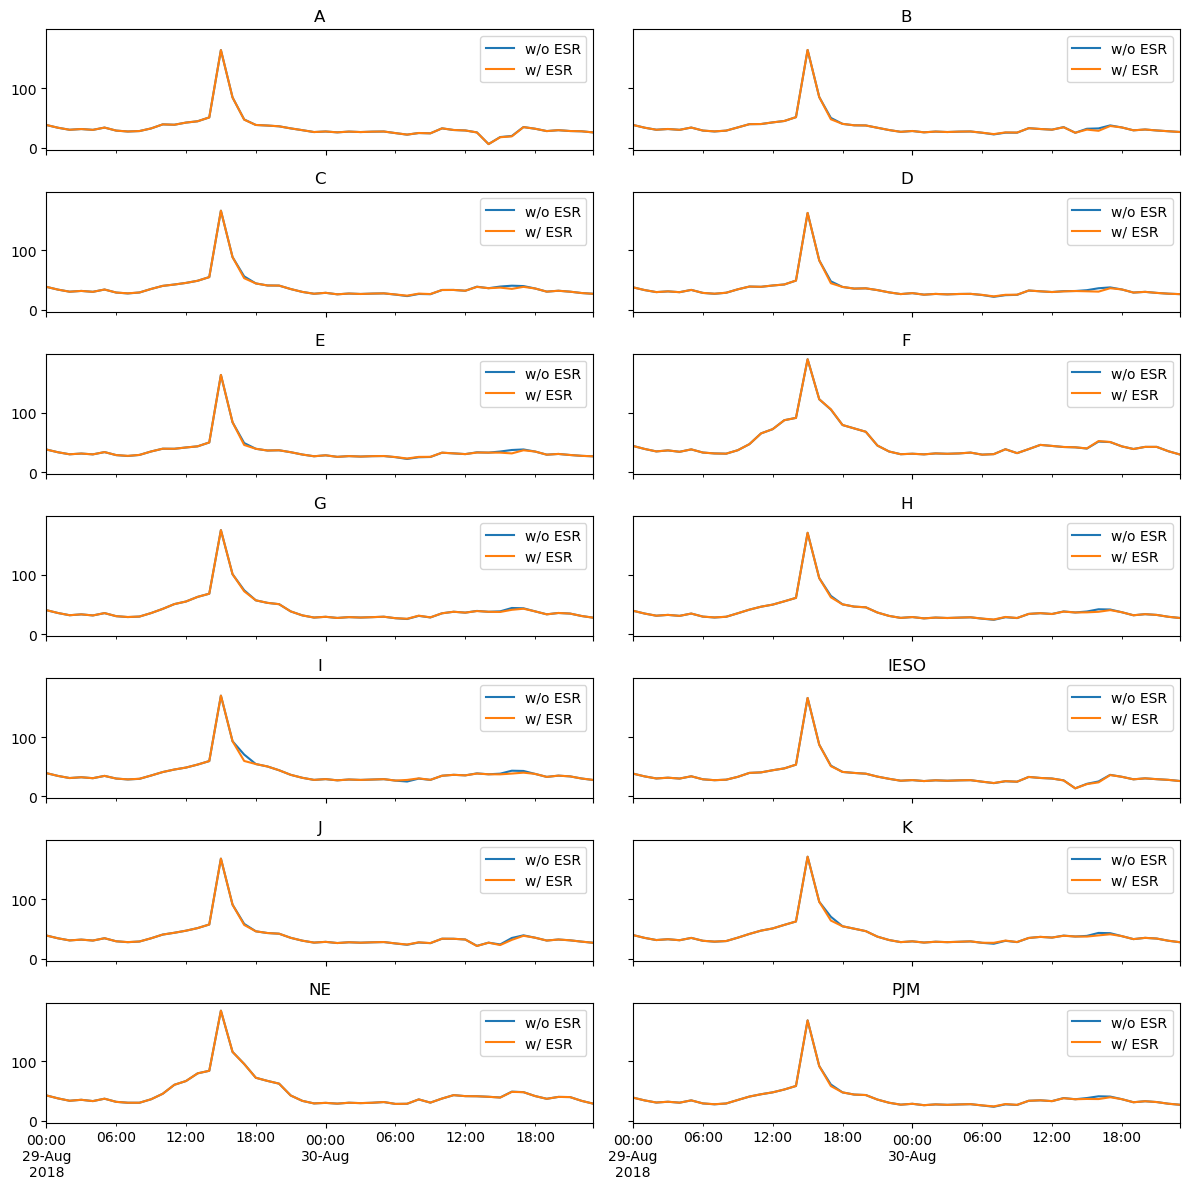

In [62]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), sharex='all', sharey='all')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_wo_esr_zone.iloc[:, i].plot(ax=ax, label='w/o ESR')
    lmp_w_esr_zone.iloc[:, i].plot(ax=ax, label='w/ ESR')
    ax.set_title(lmp_w_esr_zone.columns[i])
    ax.legend()
    
fig.tight_layout()

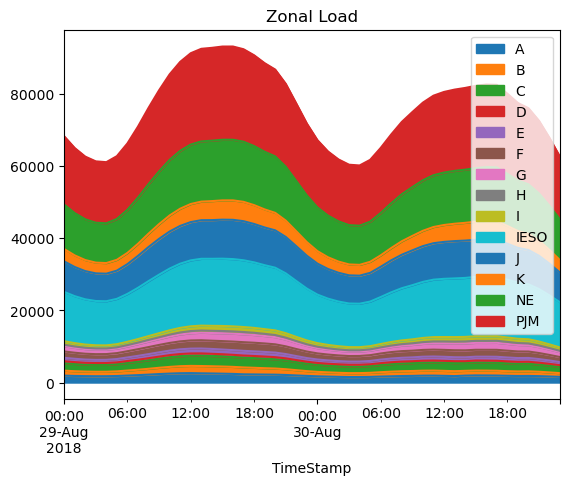

In [63]:
load_profile.columns = bus_names
load_profile_zone = load_profile.groupby(bus_zone_alloc, axis=1).sum()
load_profile_zone[start_datetime:end_datetime].plot.area(title="Zonal Load")

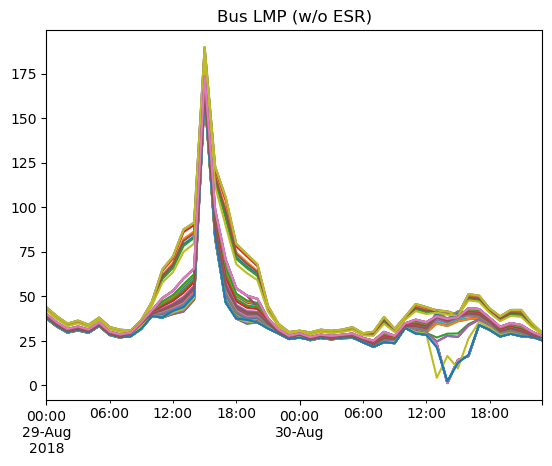

In [64]:
results_0_wo_esr['LMP'].plot(legend=False, title="Bus LMP (w/o ESR)")
plt.show()

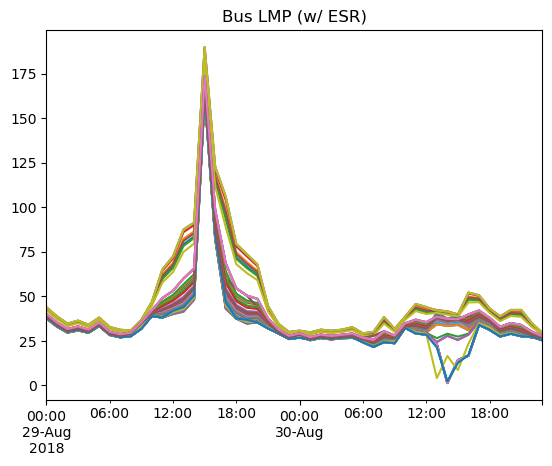

In [65]:
results_0_w_esr['LMP'].plot(legend=False, title="Bus LMP (w/ ESR)")
plt.show()

In [66]:
gen_max = genmax_profile[start_datetime:end_datetime]
gen_pg = results_0_wo_esr['PG'].iloc[:, :303]
gen_pg.columns = gen_max.columns
surplus = gen_max - gen_pg
surplus

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen294,Gen295,Gen296,Gen297,Gen298,Gen299,Gen300,Gen301,Gen302,Gen303
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-08-29 00:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 01:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,0.000000e+00,8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 02:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 03:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 04:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,-8.881784e-16,-8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 05:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 06:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,-3.552714e-15,0.0,0.000000e+00
2018-08-29 07:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 08:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00


### With initial conditions

In [67]:
# Only run for one day
d = d+1
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-08-30 00:00:00
End time: 2018-08-31 23:00:00


#### Without ESR

In [68]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_1_wo_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=None,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_1_wo_esr.set_load_sch(load_profile)
nygrid_sim_1_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_wo_esr.relax_external_branch_lim()

# Set generator initial condition
# last_gen = results_0_wo_esr['PG'].iloc[-1,:].to_numpy().squeeze()
last_gen = results_0_wo_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_wo_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_wo_esr.solve_dc_opf()

# Get results
results_1_wo_esr = nygrid_sim_1_wo_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 311
Number of branches: 94
Number of time periods: 48
Number of variables: 64944
Number of constraints: 80016
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpypgwibcw.pyomo.lp
Reading time = 0.34 seconds
x64945: 80017 rows, 64945 columns, 402339 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 80017 rows, 64945 columns and 402339 nonzeros
Model fingerprint: 0xf9895bf2
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 73880 rows and 4

In [69]:
print("s_ramp_up", results_1_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_1_wo_esr['s_load_shed'].sum())
print("s_if_max", results_1_wo_esr['s_if_max'].sum())
print("s_if_min", results_1_wo_esr['s_if_min'].sum())
print("s_br_max", results_1_wo_esr['s_br_max'].sum())
print("s_br_min", results_1_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [70]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_1_w_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=esr_prop,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_esr.set_load_sch(load_profile)
nygrid_sim_1_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_esr.relax_external_branch_lim()

# Set generator initial condition
# last_gen = results_0_w_esr['PG'].iloc[-1,:].to_numpy().squeeze()
last_gen = results_0_w_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_gen_init_data(gen_init=last_gen)

# Set options
# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_esr.solve_dc_opf()

# Get results
results_1_w_esr = nygrid_sim_1_w_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 341
Number of branches: 94
Number of time periods: 48
Number of variables: 73584
Number of constraints: 94446
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmp7gm9vo03.pyomo.lp
Reading time = 0.41 seconds
x73585: 94447 rows, 73585 columns, 432519 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 94447 rows, 73585 columns and 432519 nonzeros
Model fingerprint: 0x2d8bbba8
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 86723 rows and 5

In [71]:
print("s_ramp_up", results_1_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_esr['s_if_max'].sum())
print("s_if_min", results_1_w_esr['s_if_min'].sum())
print("s_br_max", results_1_w_esr['s_br_max'].sum())
print("s_br_min", results_1_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


## Process the results

In [72]:
# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [73]:
# Format results
results_pg_0_wo_esr = results_0_wo_esr['PG']
thermal_pg_0_wo_esr = results_pg_0_wo_esr.iloc[:, :num_thermal]
thermal_pg_0_wo_esr = thermal_pg_0_wo_esr.rename(columns=gen_rename)
print(thermal_pg_0_wo_esr.head())

results_pg_0_w_esr = results_0_w_esr['PG']
thermal_pg_0_w_esr = results_pg_0_w_esr.iloc[:, :num_thermal]
thermal_pg_0_w_esr = thermal_pg_0_w_esr.rename(columns=gen_rename)
print(thermal_pg_0_w_esr.head())

results_pg_1_wo_esr = results_1_wo_esr['PG']
thermal_pg_1_wo_esr = results_pg_1_wo_esr.iloc[:, :num_thermal]
thermal_pg_1_wo_esr = thermal_pg_1_wo_esr.rename(columns=gen_rename)
print(thermal_pg_1_wo_esr.head())

results_pg_1_w_esr = results_1_w_esr['PG']
thermal_pg_1_w_esr = results_pg_1_w_esr.iloc[:, :num_thermal]
thermal_pg_1_w_esr = thermal_pg_1_w_esr.rename(columns=gen_rename)
print(thermal_pg_1_w_esr.head())

                     59 St.  GT 1  74 St.  GT 1  74 St.  GT 2  Allegany  \
2018-08-29 00:00:00           0.0           0.0           0.0      66.0   
2018-08-29 01:00:00           0.0           0.0           0.0      66.0   
2018-08-29 02:00:00           0.0           0.0           0.0      66.0   
2018-08-29 03:00:00           0.0           0.0           0.0      66.0   
2018-08-29 04:00:00           0.0           0.0           0.0      66.0   

                     Allied Frozen Storage  Arthur Kill Cogen  \
2018-08-29 00:00:00                    0.1               11.1   
2018-08-29 01:00:00                    0.1               11.1   
2018-08-29 02:00:00                    0.1               11.1   
2018-08-29 03:00:00                    0.1               11.1   
2018-08-29 04:00:00                    0.1               11.1   

                     Arthur Kill GT 1  Arthur Kill ST 2  Arthur Kill ST 3  \
2018-08-29 00:00:00              20.0             349.0             539.0   
2018

In [74]:
def plot_gen(thermal_pg, gen_profile, genmax_profile, genmin_profile, i, title=None, ax=None):

    ax.plot(thermal_pg.index, thermal_pg.iloc[:, i], marker='*', label='OPF')
    ax.plot(thermal_pg.index, gen_profile[start_datetime:end_datetime].iloc[:,i], marker='o', label='historical')
    ax.plot(thermal_pg.index, genmax_profile[start_datetime:end_datetime].iloc[:,i], linestyle='--', label='max')
    ax.plot(thermal_pg.index, genmin_profile[start_datetime:end_datetime].iloc[:,i], linestyle='--', label='min')
    ax.legend()
    ax.set_title(title)

    return ax

In [75]:
gen_profile[start_datetime:end_datetime]

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen294,Gen295,Gen296,Gen297,Gen298,Gen299,Gen300,Gen301,Gen302,Gen303
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-08-30 00:00:00,0.0,0.0,0.0,66.0,0.0,11.1,0.0,349.0,539.0,1.0,...,2.660778,34.312951,1.773852,0.388030,7.982334,6.651945,5.099825,33.093428,68.515037,24.390466
2018-08-30 01:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,96.0,1.0,1.0,...,2.648160,34.150228,1.765440,0.386190,7.944479,6.620400,5.075640,32.936488,68.190116,24.274798
2018-08-30 02:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,96.0,1.0,1.0,...,2.656572,34.258710,1.771048,0.387417,7.969716,6.641430,5.091763,33.041115,68.406730,24.351910
2018-08-30 03:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,96.0,1.0,1.0,...,2.656572,34.258710,1.771048,0.387417,7.969716,6.641430,5.091763,33.041115,68.406730,24.351910
2018-08-30 04:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,96.0,1.0,1.0,...,2.643954,34.095987,1.762636,0.385577,7.931861,6.609884,5.067578,32.884175,68.081809,24.236243
2018-08-30 05:00:00,0.0,0.0,0.0,66.0,0.1,0.0,0.0,96.0,1.0,1.0,...,2.665825,34.378041,1.777217,0.388766,7.997476,6.664564,5.109499,33.156204,68.645005,24.436733
2018-08-30 06:00:00,0.0,0.0,0.0,11.0,0.0,0.0,0.0,96.0,1.0,1.0,...,2.664143,34.356344,1.776095,0.388521,7.992429,6.660358,5.106274,33.135279,68.601682,24.421311
2018-08-30 07:00:00,0.0,0.0,0.0,11.0,0.0,0.0,0.0,151.2,1.0,1.0,...,2.692744,34.725184,1.795163,0.392692,8.078233,6.731861,5.161094,33.491009,69.338170,24.683491
2018-08-30 08:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,349.0,223.7,1.0,...,2.736488,35.289292,1.824325,0.399071,8.209464,6.841220,5.244935,34.035068,70.464564,25.084472


NYISOName              Allegany
PTID                      23514
Zone                          B
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.5083
Longitude              -78.0661
maxPower                   66.0
minPower                   11.0
maxRampAgc                  6.6
maxRamp10                  66.0
maxRamp30                  66.0
maxRamp60                  66.0
HeatRateLM_1           8.218122
HeatRateLM_0         -14.577671
HeatRateLM_R2          0.862443
HeatRateQM_2          -0.094773
HeatRateQM_1           15.20904
HeatRateQM_0        -125.857658
HeatRateQM_R2          0.891407
useQM                         1
start-time                  10m
Name: 3, dtype: object


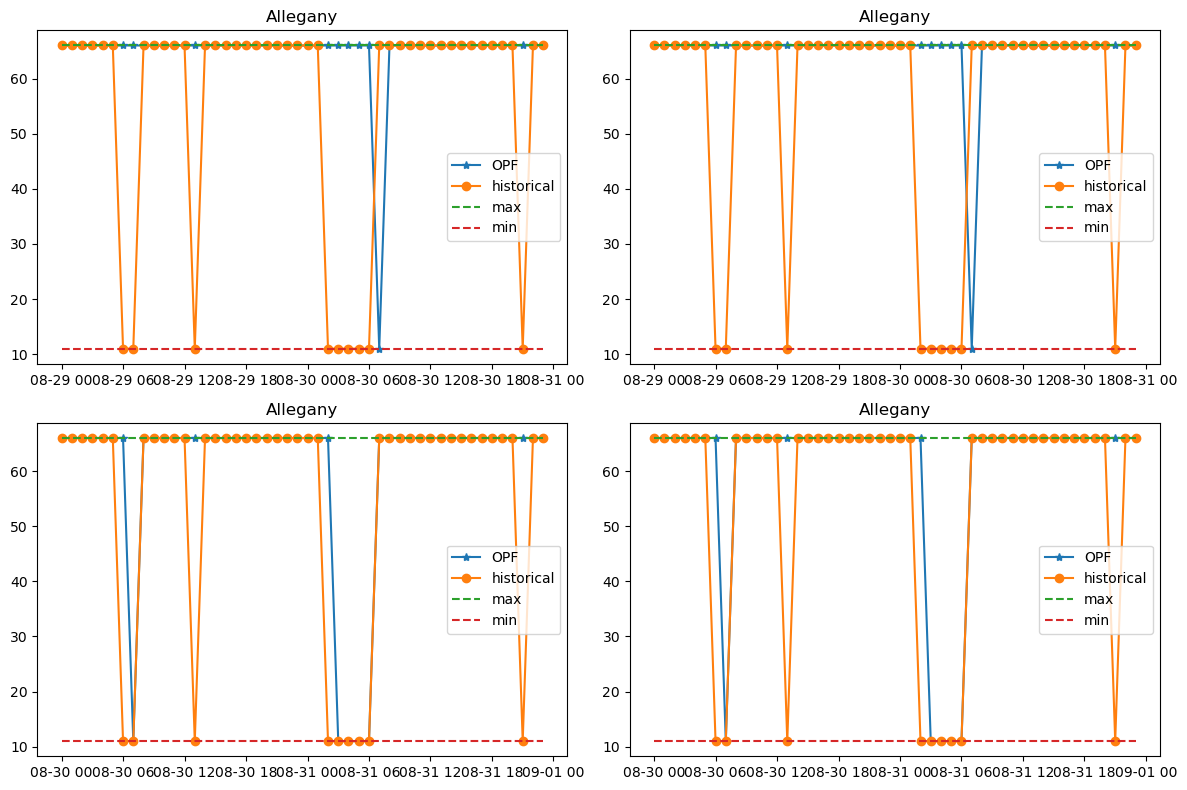

In [76]:
ii = 3
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
fig.tight_layout()

NYISOName            Astoria 2
PTID                     24149
Zone                         J
UnitType         Steam Turbine
FuelType           Natural Gas
Latitude               40.7869
Longitude             -73.9122
maxPower                 153.0
minPower                   1.0
maxRampAgc                15.3
maxRamp10                153.0
maxRamp30                153.0
maxRamp60                153.0
HeatRateLM_1         10.720159
HeatRateLM_0        147.545513
HeatRateLM_R2         0.987563
HeatRateQM_2          0.007555
HeatRateQM_1          9.621049
HeatRateQM_0        170.560114
HeatRateQM_R2          0.98891
useQM                        1
start-time                 10m
Name: 9, dtype: object


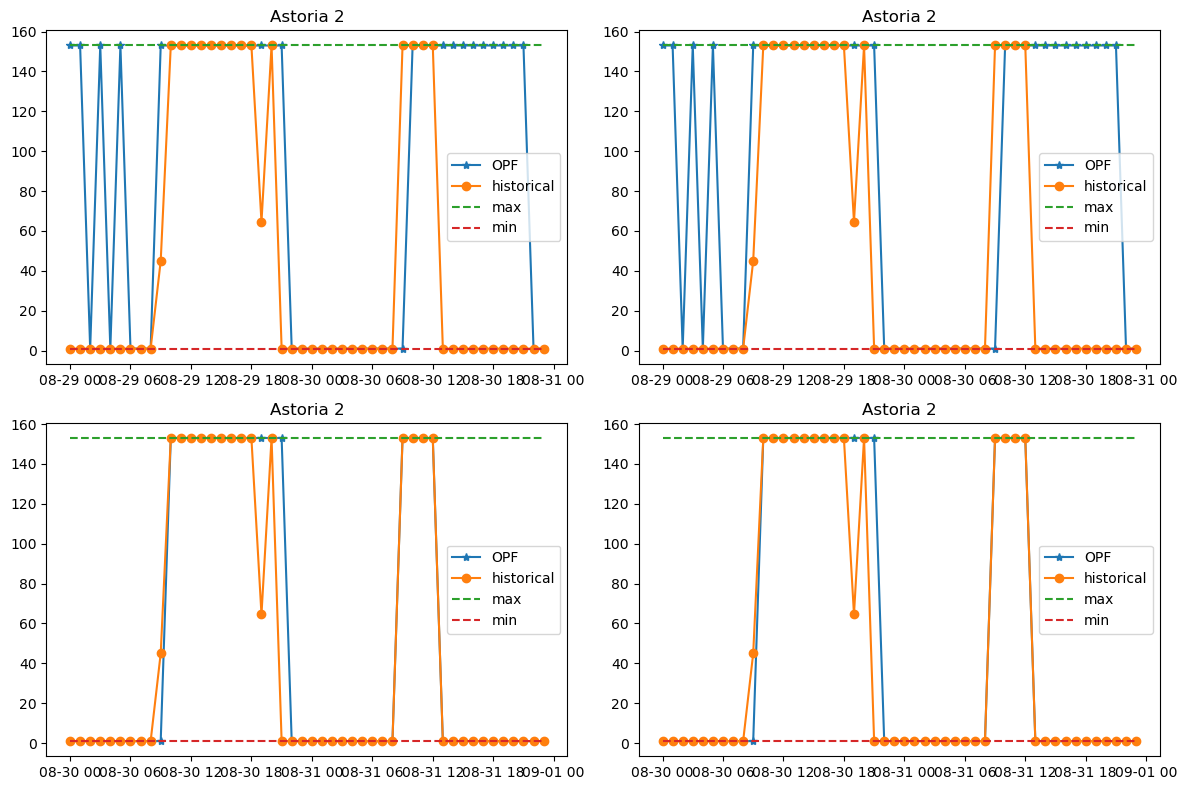

In [77]:
ii = 9
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
fig.tight_layout()


NYISOName          East River 2
PTID                     323559
Zone                          J
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                40.7281
Longitude              -73.9742
maxPower                  227.0
minPower                   83.0
maxRampAgc                2.325
maxRamp10                 23.25
maxRamp30                 69.75
maxRamp60                 139.5
HeatRateLM_1           7.653993
HeatRateLM_0         446.985488
HeatRateLM_R2           0.98562
HeatRateQM_2           0.006054
HeatRateQM_1           5.870358
HeatRateQM_0          567.52178
HeatRateQM_R2          0.986302
useQM                         1
start-time                  12h
Name: 83, dtype: object


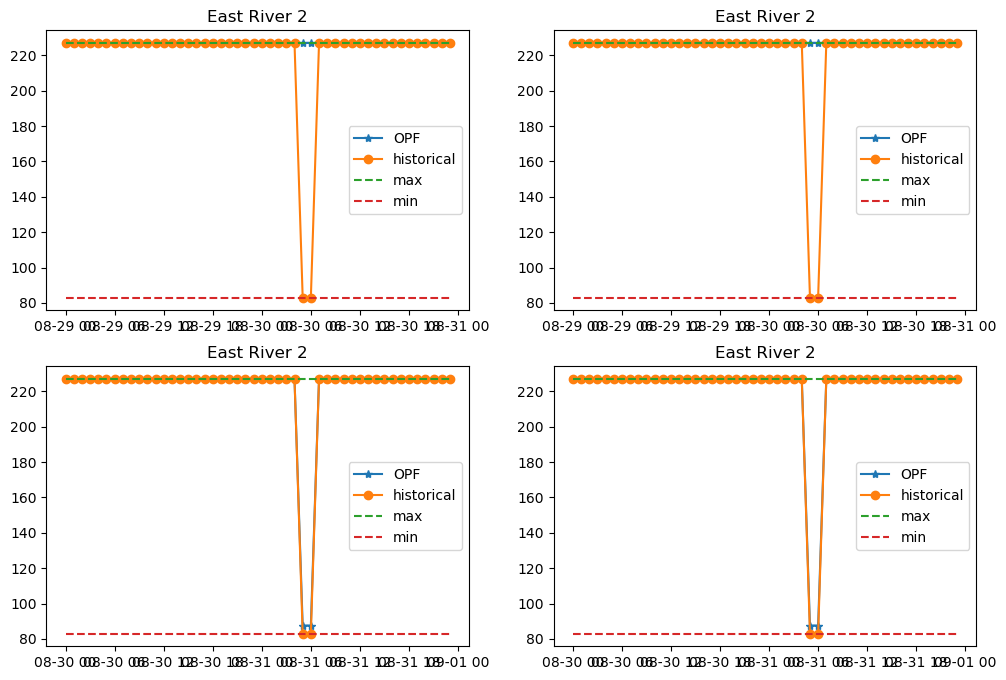

In [78]:
ii = 83
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
plt.show()